### API
- Application Programming Interface의 약자
- api를 사용해서 데이터를 수집하는 것은 서비스에 데이터를 제공하는 공식적인 방법

- Naver Rest API
    - 파파고 번역 api
    - 통합검색어 트렌드 api

In [18]:
import pandas as pd
import requests, json

#### 0. request token(app key) 얻기
- `https://developers.naver.com`
- 1. Request Token 얻기 : 애플리케이션등록 -> app_key 획득
- 2. app_key를 이용해서 데이터 가져오기

In [19]:
CLIENT_ID, CLIENT_SECRET = 'gH6hzvV1mLJBvdWMlHOI', 'o60OiakwfP'

#### 1. 파파고 번역 api
- Naver API Document 확인 > URL
    - `https://developers.naver.com/docs/papago/`
- API Reference
    - `https://developers.naver.com/docs/papago/papago-nmt-api-reference.md`
- 예제 내 -H: 헤더, -d: 데이터
- 일일 API 사용량 넘을 시 사용 불가

In [20]:
# 1. URL
url = "https://openapi.naver.com/v1/papago/n2mt"

In [21]:
# 2. request(url, app_key) > response(json) : JSON(str)
msg = "이것은 예시 문장입니다."
params = { "source": "ko", "target": "en", "text": msg }
headers = {
    "Content-Type": "application/json", # reference site의 값을 넣어서 에러 생길 경우 dev 커뮤니티에 문의
    "X-Naver-Client-Id": CLIENT_ID,
    "X-Naver-Client-Secret": CLIENT_SECRET,
}
response = requests.post(url, json.dumps(params), headers=headers) 
# json.dumps(): 한글과 같은 문자를 유니코드 인코딩
response

<Response [200]>

In [22]:
# 3. parsing : JSON(str) > list, dict > DataFrame
response.json()["message"]["result"]["translatedText"]

'This is an example sentence.'

In [23]:
# 4. 함수로 만들기
def translate(msg):
    url = "https://openapi.naver.com/v1/papago/n2mt"
    params = { "source": "ko", "target": "en", "text": msg }
    headers = {
        "Content-Type": "application/json",
        "X-Naver-Client-Id": CLIENT_ID,
        "X-Naver-Client-Secret": CLIENT_SECRET,
    }
    response = requests.post(url, json.dumps(params), headers=headers)
    return response.json()["message"]["result"]["translatedText"]

In [24]:
msg = "데이터 분석 및 크롤링"
translated_text = translate(msg)
translated_text

'Data Analysis and Crawling'

In [25]:
# 한글 excel 파일을 영문 excel 파일로 변경
covid = pd.read_excel('./data/covid.xlsx')
covid.tail(2)

,category,link,title,content
4,104,https://news.naver.com/main/read.nhn?mode=LSD&...,"""코로나 확진자 '0명'인 날은 절대 오지 않는다"" 美전문가","""주기적 발병…미국서 항상 어느 정도의 확산 있을 것""""팬데믹 초기와는 다를 것…백..."
5,104,https://news.naver.com/main/read.nhn?mode=LSD&...,올림픽 다가오는데 도쿄 코로나 확산 빨라져...일주일새 25％↑,올림픽 개막이 다가오는 가운데 개최지 일본 도쿄에서 코로나19 확산 속도가 빨라...


In [26]:
covid_en = covid['title'].apply(translate)
covid['title_en'] = covid_en

In [27]:
covid.to_excel('./data/covid_en.xlsx', index=False, encoding="utf-8-sig")
# utf-8-sig: excel에서 사용하는 인코딩 방식과 호환이 되는 utf-8 인코딩 방식

#### 2. 네이버 검색어 트렌드 수집
- 서비스 : `https://datalab.naver.com/keyword/trendSearch.naver`
- 내 애플리케이션 > dss 애플리케이션 > API 설정 > 데이터랩(검색어 트렌드) 추가
- 사용법 : `https://developers.naver.com/docs/serviceapi/datalab/search/search.md#통합-검색어-트렌드`

In [28]:
import pandas as pd
import requests, json

In [29]:
# 1. application key
CLIENT_ID, CLIENT_SECRET = 'gH6hzvV1mLJBvdWMlHOI', 'o60OiakwfP'

In [30]:
# 2. document : URL, params, headers
url = "https://openapi.naver.com/v1/datalab/search"

params = {
    "startDate": "2018-01-01",
    "endDate": "2022-01-31",
    "timeUnit": "month",
    "keywordGroups": [
        {"groupName": "트위터", "keywords": ["트위터", "트윗"]},
        {"groupName": "페이스북", "keywords": ["페이스북", "페북"]},
        {"groupName": "인스타그램", "keywords": ["인스타그램", "인스타"]},
    ]
}

headers = {
    "Content-Type": "application/json",
    "X-Naver-Client-Id": CLIENT_ID,
    "X-Naver-Client-Secret": CLIENT_SECRET,    
}

In [31]:
# 3. request(url, params, headers) > response(json) : JSON(str)
response = requests.post(url, data=json.dumps(params), headers=headers)
response

<Response [200]>

In [32]:
# 4. JSON(str) > preprocessing > DataFrame
datas = response.json()["results"]

dfs = []
for data in datas:
    df = pd.DataFrame(data["data"])
    df["title"] = data["title"] # 트위터, 페이스북, 인스타그램
    dfs.append(df)

result_df = pd.concat(dfs, ignore_index=True)
result_df.tail(2)

,period,ratio,title
145,2021-12-01,22.87539,인스타그램
146,2022-01-01,22.08050,인스타그램


In [33]:
pivot_df = result_df.pivot("period", "title", "ratio")
pivot_df.columns = ["instagram", "twitter", "facebook"]
pivot_df.tail(2)

,instagram,twitter,facebook
period,,,
2021-12-01,22.87539,21.55931,27.23295
2022-01-01,22.08050,21.94339,25.93933


<AxesSubplot:xlabel='period'>

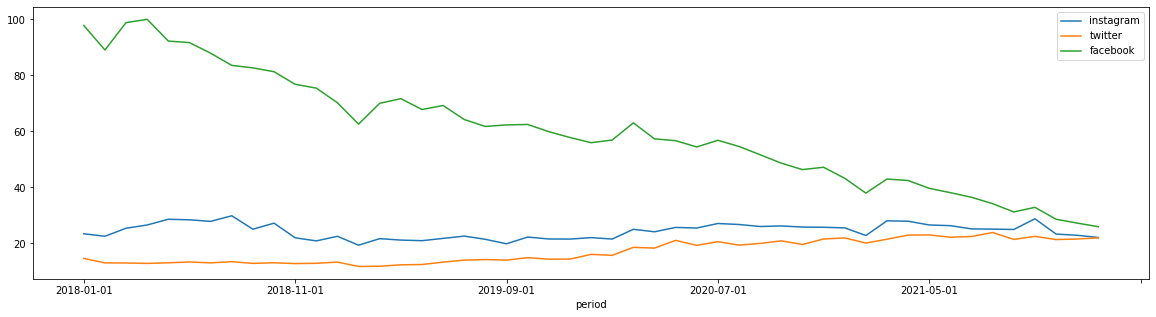

In [34]:
# 5. visualization
pivot_df.plot(figsize=(20, 5))